In [60]:
using JLD2, GpABC, Plots, StatsBase, LaTeXStrings, Plots.Measures, DataFrames, CSV

In [50]:
df_nuc = DataFrame(CSV.File("/users/jamesh/GitHub/volume-inference-take-2/data/nuclear-vol-corr.csv"));
df_cyto = DataFrame(CSV.File("/users/jamesh/GitHub/volume-inference-take-2/data/cyto-vol-corr.csv"));
delete!(df_nuc, 2);
delete!(df_cyto, 2);

gnames = df_cyto[!,"gene"]
Ns = df_nuc[!,"N"];
cyto_means = df_cyto[!,"Mean"];
nuc_FFs = df_nuc[!,"FF"];
cyto_FFs = df_cyto[!,"FF"];

In [85]:
Plots.theme(:dao)
Plots.gr_cbar_width[] = 0.01;
pal = cgrad(:tol_muted);
cpal = [pal[i] for i in 1/7:1/7:1.0]
population_colors = cpal

In [87]:
include("/users/jamesh/GitHub/volume-inference-take-2/SSA-basic.jl")
using .SSAnonVD

# bub1WTymEGFP

In [106]:
gn = 1;

In [96]:
tdeg = 1; hypars = [3,3]
texpt(kA,kB,kC,S,R) = 1/kC;
tinit(kA,kB,kC,S,R) = (1/kB)+(S-1)/kA;

In [97]:
function sim_time(pars)
    kA, kB, kC = pars;
    return 10*maximum([1,texpt(pars...,hypars...),tinit(pars...,hypars...)])
end

sim_time (generic function with 1 method)

In [94]:
function simulator_fn(gn, pars)
    op = SSA(Ns[gn], pars, hypars, sim_time(pars), sim_time(pars));
    nuc_pop = op[1][:,2];
    cyto_pop = op[2][:,2];
    nuc_FF = var(nuc_pop)/mean(nuc_pop);
    cyto_mean = 2*mean(cyto_pop);
    cyto_FF = var(cyto_pop)/mean(cyto_pop);
    # return the moments of interest
    return reshape([cyto_mean, nuc_FF, cyto_FF],(3,1))
end

simulator_fn (generic function with 1 method)

In [107]:
bub1 = load("./S3R3allGenes/S3R3_$(gnames[gn]).jld2", "ABC");

In [120]:
plot(bub1, population_colors=population_colors)

Let's collect the important aspects of this ABC for analysis. We want:
- 1. The parameter values of the accepted particles.
- 2. The acceptance rate for the final threshold.

Note the different field names are: `n_accepted`, `n_tries`, `threshold_schedule`, `population`, `distances`, `weights`.

In [119]:
acc_rate = bub1.n_accepted[end]/bub1.n_tries[end]

0.017030842856412962

So the acceptance rate at the final threshold was around 0.2. Let's now look at the mean and standard deviations of the predicted values of $k_A$, $k_B$ and $k_C$ from the population.

In [64]:
pop_bub1 = bub1.population[end];

In [65]:
kA_bub1 = pop[:,1]; kB_bub1 = pop[:,2]; kC_bub1 = pop[:,3];

In [66]:
kAmed_bub1 = median(kA_bub1)

4.592101681331336

In [67]:
kAstd_bub1 = std(kA_bub1)

0.13836742668741628

In [68]:
kBmed_bub1 = median(kB_bub1)

34.489989969820904

In [69]:
kBstd_bub1 = std(kB_bub1)

12.234634211250878

In [70]:
kCmed_bub1 = median(kC_bub1)

44.47229155820551

In [71]:
kCstd_bub1 = std(kC_bub1)

11.674043085460394

Let's make some nice plots of these (the three histograms followed by the joint uncertainty plots as a 2D hist).

In [72]:
h1 = stephist(kA_bub1, fill = true, fillalpha = 0.5, color = cpal[1], label = :none, norm = true, titlelocation = :left)
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), xlabel = L"k_A", title = "(a)", ylims = [0,3.5])
plot!([kAmed_bub1,kAmed_bub1],[0,100], style = :dash, color = :black, label = L"$k_C$ median")

In [73]:
h2 = stephist(kB_bub1, fill = true, fillalpha = 0.5, color = cpal[2], label = :none, norm = true, titlelocation = :left)
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), xlabel = L"k_B", title = "(b)", ylims = [0,0.04])
plot!([kBmed_bub1,kBmed_bub1],[0,1.2], style = :dash, color = :black, label = L"$k_B$ median")

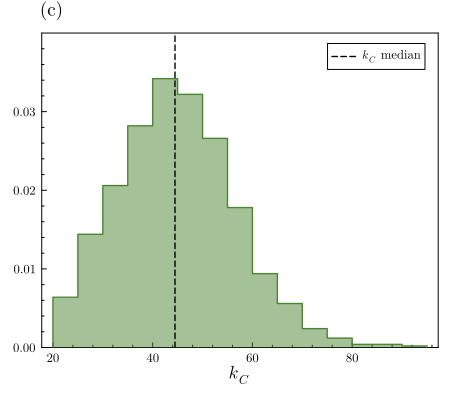

In [74]:
h3 = stephist(kC_bub1, fill = true, fillalpha = 0.5, color = cpal[3], label = :none, norm = true, titlelocation = :left)
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), xlabel = L"k_C", 
        title = "(c)", ylims = [0,0.04])
plot!([kCmed_bub1,kCmed_bub1],[0,2], style = :dash, color = :black, label = L"$k_C$ median")

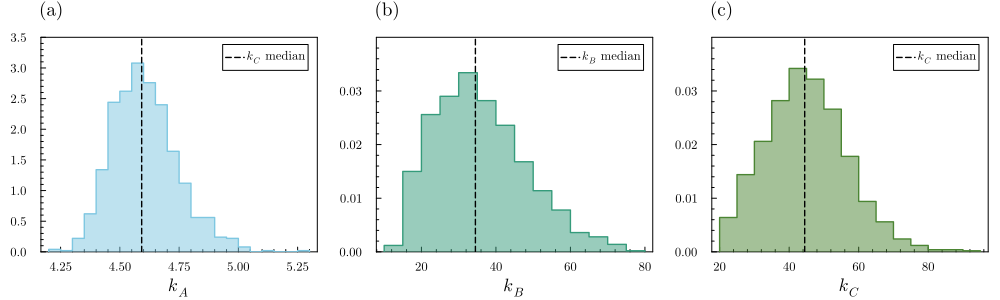

In [75]:
c1 = plot(h1, h2, h3, layout = (1,3), size = (1000, 300), bottom_margin = 5mm, top_margin = 5mm)

In [76]:
p1 = histogram2d(kA_bub1, kB_bub1, color=:tol_muted, show_empty_bins=true, titlelocation = :left, 
    bins = (collect(minimum(kA_bub1):(maximum(kA_bub1)-minimum(kA_bub1))/15:maximum(kA_bub1)), collect(minimum(kB_bub1):(maximum(kB_bub1)-minimum(kB_bub1))/15:maximum(kB_bub1))))
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), 
    xlabel = L"k_A", ylabel = L"k_B", title = "(d)");

In [77]:
p2 = histogram2d(kA_bub1, kC_bub1, color=:tol_muted, show_empty_bins=true, titlelocation = :left, 
    bins = (collect(minimum(kA_bub1):(maximum(kA_bub1)-minimum(kA_bub1))/15:maximum(kA_bub1)), collect(minimum(kC_bub1):(maximum(kC_bub1)-minimum(kC_bub1))/15:maximum(kC_bub1))))
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), 
    xlabel = L"k_A", ylabel = L"k_C", title = "(e)");

In [78]:
p3 = histogram2d(kB_bub1, kC_bub1, color=:tol_muted, show_empty_bins=true, titlelocation = :left, 
    bins = (collect(minimum(kB_bub1):(maximum(kB_bub1)-minimum(kB_bub1))/15:maximum(kB_bub1)), collect(minimum(kC_bub1):(maximum(kC_bub1)-minimum(kC_bub1))/15:maximum(kC_bub1))))
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), 
    xlabel = L"k_B", ylabel = L"k_C", title = "(f)");

In [79]:
c2 = plot(p1, p2, p3, layout = (1,3), size = (1000, 300), bottom_margin = 5mm, top_margin = 5mm, left_margin = 5.0mm, right_margin = -10mm);

In [80]:
plot(c1,c2, layout = (2,1), size = (1000,600), plot_title=L"%$(gnames[gn]): $S=R=3$")
savefig("./figs/S3R3_$(gnames[gn]).pdf")

"/users/jamesh/GitHub/volume-inference-take-2/S3R3allGenes/figs/S3R3_bub1WTymEGFP.pdf"

Check if the moments replicate those from the original data.

In [81]:
[cyto_means[gn],nuc_FFs[gn],cyto_FFs[gn]]

3-element Vector{Float64}:
 4.40026352075131
 0.951474200744362
 0.620914621534717

In [98]:
mean([simulator_fn(1,[kAmed_bub1,kBmed_bub1,kCmed_bub1]) for i in 1:100])

3×1 Matrix{Float64}:
 4.400140105078808
 0.955682103626032
 0.6484582045313527

So, pretty good overall.

# mad1WTymEGFP

In [109]:
gn = 2;
gnames[2]

"mad1WTymEGFP"

In [110]:
tdeg = 1; hypars = [3,3]
texpt(kA,kB,kC,S,R) = 1/kC;
tinit(kA,kB,kC,S,R) = (1/kB)+(S-1)/kA;

In [111]:
function sim_time(pars)
    kA, kB, kC = pars;
    return 10*maximum([1,texpt(pars...,hypars...),tinit(pars...,hypars...)])
end

sim_time (generic function with 1 method)

In [112]:
function simulator_fn(gn, pars)
    op = SSA(Ns[gn], pars, hypars, sim_time(pars), sim_time(pars));
    nuc_pop = op[1][:,2];
    cyto_pop = op[2][:,2];
    nuc_FF = var(nuc_pop)/mean(nuc_pop);
    cyto_mean = 2*mean(cyto_pop);
    cyto_FF = var(cyto_pop)/mean(cyto_pop);
    # return the moments of interest
    return reshape([cyto_mean, nuc_FF, cyto_FF],(3,1))
end

simulator_fn (generic function with 1 method)

In [113]:
mad1GFP = load("./S3R3allGenes/S3R3_$(gnames[gn]).jld2", "ABC");

In [114]:
plot(mad1GFP, population_colors=population_colors)

Let's collect the important aspects of this ABC for analysis. We want:
- 1. The parameter values of the accepted particles.
- 2. The acceptance rate for the final threshold.

Note the different field names are: `n_accepted`, `n_tries`, `threshold_schedule`, `population`, `distances`, `weights`.

In [129]:
acc_rate = mad1GFP.n_accepted[end]/mad1GFP.n_tries[end]

0.01255224873536094

So the acceptance rate at the final threshold was around 0.2. Let's now look at the mean and standard deviations of the predicted values of $k_A$, $k_B$ and $k_C$ from the population.

In [121]:
pop_mad1GFP = mad1GFP.population[end];

In [124]:
kA_mad1GFP = pop_mad1GFP[:,1]; kB_mad1GFP = pop_mad1GFP[:,2]; kC_mad1GFP = pop_mad1GFP[:,3];

In [125]:
kAmed_mad1GFP = median(kA_mad1GFP)

3.0106196132365666

In [130]:
kAstd_mad1GFP = std(kA_mad1GFP)

0.06188302082990782

In [131]:
kBmed_mad1GFP = median(kB_mad1GFP)

23.14789456748635

In [132]:
kBstd_mad1GFP = std(kB_mad1GFP)

4.852092029747582

In [133]:
kCmed_mad1GFP = median(kC_mad1GFP)

95.24452349192714

In [134]:
kCstd_mad1GFP = std(kC_mad1GFP)

24.967466316700975

Let's make some nice plots of these (the three histograms followed by the joint uncertainty plots as a 2D hist).

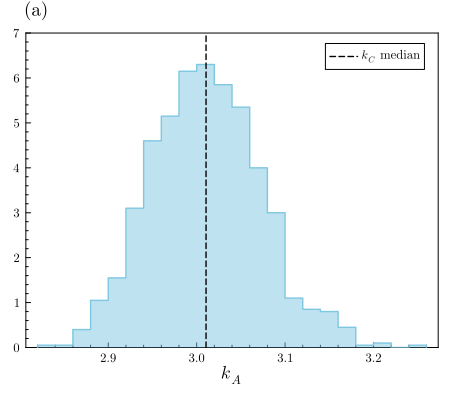

In [138]:
h1 = stephist(kA_mad1GFP, fill = true, fillalpha = 0.5, color = cpal[1], label = :none, norm = true, titlelocation = :left)
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), xlabel = L"k_A", title = "(a)", ylims = [0,7.0])
plot!([kAmed_mad1GFP,kAmed_mad1GFP],[0,100], style = :dash, color = :black, label = L"$k_C$ median")

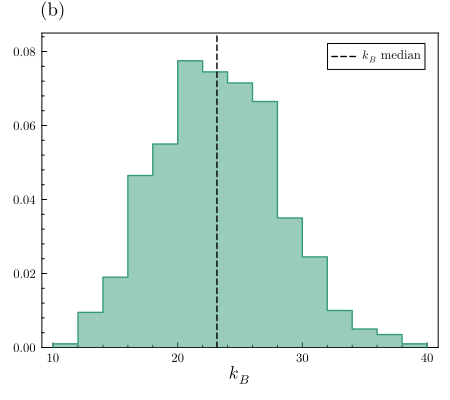

In [141]:
h2 = stephist(kB_mad1GFP, fill = true, fillalpha = 0.5, color = cpal[2], label = :none, norm = true, titlelocation = :left)
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), xlabel = L"k_B", title = "(b)", ylims = [0,0.085])
plot!([kBmed_mad1GFP,kBmed_mad1GFP],[0,1.2], style = :dash, color = :black, label = L"$k_B$ median")

In [143]:
h3 = stephist(kC_mad1GFP, fill = true, fillalpha = 0.5, color = cpal[3], label = :none, norm = true, titlelocation = :left)
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), xlabel = L"k_C", 
        title = "(c)", ylims = [0,0.018])
plot!([kCmed_mad1GFP,kCmed_mad1GFP],[0,2], style = :dash, color = :black, label = L"$k_C$ median")

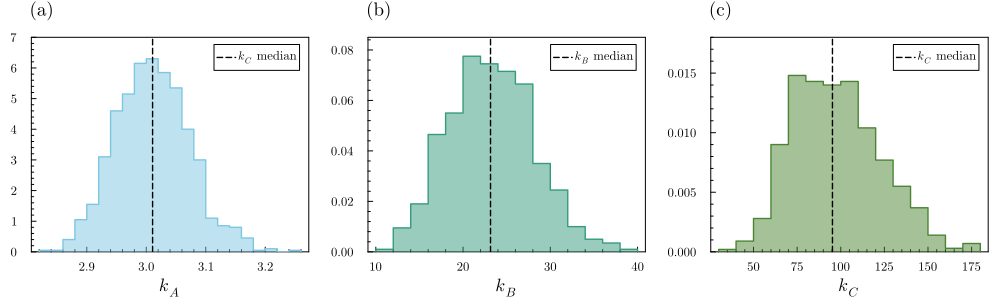

In [144]:
c1 = plot(h1, h2, h3, layout = (1,3), size = (1000, 300), bottom_margin = 5mm, top_margin = 5mm)

In [145]:
p1 = histogram2d(kA_mad1GFP, kB_mad1GFP, color=:tol_muted, show_empty_bins=true, titlelocation = :left, 
    bins = (collect(minimum(kA_mad1GFP):(maximum(kA_mad1GFP)-minimum(kA_mad1GFP))/15:maximum(kA_mad1GFP)), collect(minimum(kB_mad1GFP):(maximum(kB_mad1GFP)-minimum(kB_mad1GFP))/15:maximum(kB_mad1GFP))))
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), 
    xlabel = L"k_A", ylabel = L"k_B", title = "(d)");

In [146]:
p2 = histogram2d(kA_mad1GFP, kC_mad1GFP, color=:tol_muted, show_empty_bins=true, titlelocation = :left, 
    bins = (collect(minimum(kA_mad1GFP):(maximum(kA_mad1GFP)-minimum(kA_mad1GFP))/15:maximum(kA_mad1GFP)), collect(minimum(kC_mad1GFP):(maximum(kC_mad1GFP)-minimum(kC_mad1GFP))/15:maximum(kC_mad1GFP))))
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), 
    xlabel = L"k_A", ylabel = L"k_C", title = "(e)");

In [147]:
p3 = histogram2d(kB_mad1GFP, kC_mad1GFP, color=:tol_muted, show_empty_bins=true, titlelocation = :left, 
    bins = (collect(minimum(kB_mad1GFP):(maximum(kB_mad1GFP)-minimum(kB_mad1GFP))/15:maximum(kB_mad1GFP)), collect(minimum(kC_mad1GFP):(maximum(kC_mad1GFP)-minimum(kC_mad1GFP))/15:maximum(kC_mad1GFP))))
plot!(grid = false, minorgrid = false, legend = :topright, size = (450,400), 
    xlabel = L"k_B", ylabel = L"k_C", title = "(f)");

In [148]:
c2 = plot(p1, p2, p3, layout = (1,3), size = (1000, 300), bottom_margin = 5mm, top_margin = 5mm, left_margin = 5.0mm, right_margin = -10mm);

In [150]:
plot(c1,c2, layout = (2,1), size = (1000,600), plot_title=L"%$(gnames[gn]): $S=R=3$")
# savefig("./figs/S3R3_$(gnames[gn]).pdf")

"/users/jamesh/GitHub/volume-inference-take-2/S3R3allGenes/figs/S3R3_mad1WTymEGFP.pdf"

Check if the moments replicate those from the original data.

In [151]:
[cyto_means[gn],nuc_FFs[gn],cyto_FFs[gn]]

3-element Vector{Float64}:
 2.85251910029699
 0.982755063497557
 0.656947683997517

In [153]:
mean([simulator_fn(2,[kAmed_mad1GFP,kBmed_mad1GFP,kCmed_mad1GFP]) for i in 1:100])

3×1 Matrix{Float64}:
 2.8673503480278413
 0.9857892293407613
 0.6656150212049896

So, pretty good overall.